In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
# from pipeline import get_fitted_pipeline

warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn")

In [2]:
df = pd.read_csv(r"/Users/loganheydt/Documents/GitHub/Kaggle_competitions/Wine_Quality/data/train.csv")

# Exploration

In [3]:
df.describe()

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,8.150407,0.506026,0.229651,2.185944,0.078890,13.041077,36.893967,0.996907,3.323941,0.618216,10.183854,5.652467
std,4330.271354,1.389280,0.135077,0.178647,0.521511,0.014986,7.843052,23.956718,0.001392,0.116201,0.107910,0.900769,0.814861
min,0.000000,3.500000,0.180000,0.000000,1.100000,0.012000,0.650000,5.000000,0.990640,2.790000,0.400000,8.100000,3.000000
25%,3749.750000,7.200000,0.400000,0.050000,1.900000,0.073000,6.000000,19.000000,0.995880,3.240000,0.550000,9.500000,5.000000
50%,7499.500000,7.800000,0.510000,0.240000,2.100000,0.078000,11.000000,29.000000,0.996800,3.320000,0.590000,9.800000,6.000000
75%,11249.250000,8.900000,0.600000,0.370000,2.300000,0.084000,17.000000,48.000000,0.997800,3.390000,0.660000,10.800000,6.000000
max,14999.000000,15.800000,1.740000,0.770000,13.300000,0.415000,52.000000,152.000000,1.003690,4.010000,1.950000,15.000000,8.000000


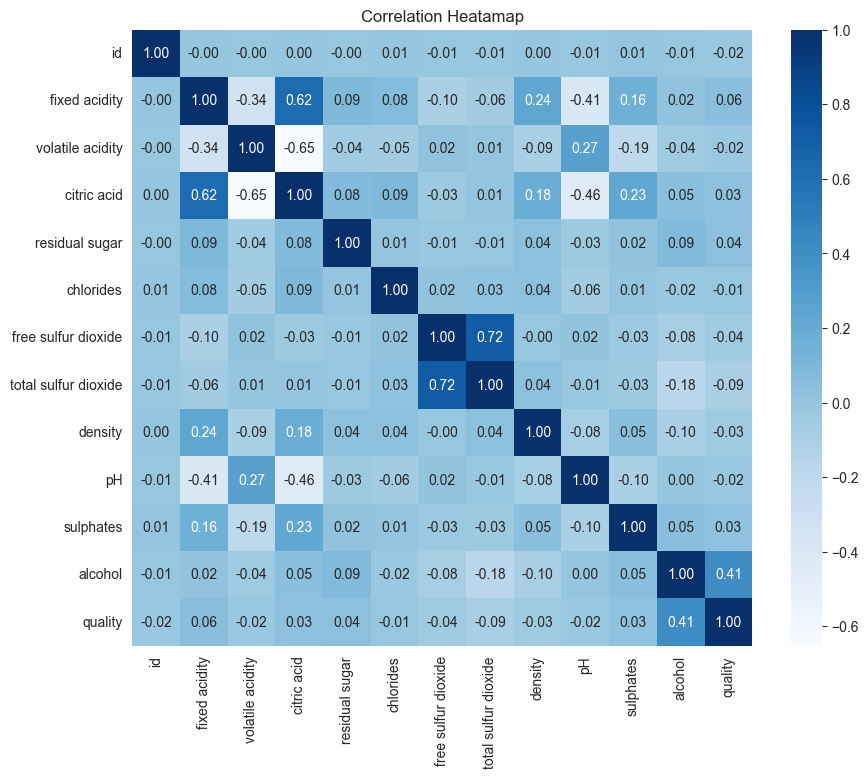

In [4]:
plt.figure(figsize=(10,8))
corr =  df.corr()
sns.heatmap(corr, cmap='Blues', annot=True, fmt=".2f")
plt.title("Correlation Heatamap")
plt.show()

In [5]:
def quadratic_correlation_table(df, target, features):
    results = []

    y = df[target].values.reshape(-1, 1)

    for col in features:
        X = df[[col]].values

        # --- Linear ---
        lin_model = LinearRegression()
        lin_model.fit(X, y)
        lin_r2 = lin_model.score(X, y)

        # --- Quadratic ---
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X)

        quad_model = LinearRegression()
        quad_model.fit(X_poly, y)
        quad_r2 = quad_model.score(X_poly, y)

        results.append({
            "feature": col,
            "linear_r2": lin_r2,
            "quadratic_r2": quad_r2,
            "improvement": quad_r2 - lin_r2
        })

    return pd.DataFrame(results).sort_values("quadratic_r2", ascending=True)

In [6]:
features = df.columns.tolist()
features = [col for col in features if col not in ['id', 'quality']]

results_df = quadratic_correlation_table(df, target='quality', features=features)

print(results_df.sort_values("improvement", ascending=False))

                 feature  linear_r2  quadratic_r2  improvement
0          fixed acidity   0.003057      0.007637     0.004581
9              sulphates   0.000729      0.002607     0.001878
2            citric acid   0.001107      0.002852     0.001744
1       volatile acidity   0.000257      0.001336     0.001079
10               alcohol   0.167449      0.167833     0.000384
8                     pH   0.000392      0.000624     0.000231
7                density   0.001206      0.001409     0.000203
4              chlorides   0.000032      0.000231     0.000199
6   total sulfur dioxide   0.008737      0.008905     0.000168
3         residual sugar   0.001687      0.001781     0.000094
5    free sulfur dioxide   0.001417      0.001443     0.000026


#### Disproves the idea of quadratic correlation ^^

In [7]:
interactions = [
    ['volatile acidity', 'total sulfur dioxide'],
    ['citric acid', 'residual sugar'],
    ['volatile acidity', 'residual sugar'],
    ['fixed acidity', 'residual sugar'],
    ['chlorides', 'alcohol'],
    ['chlorides', 'volatile acidity'],
    ['chlorides', 'fixed acidity'],
    ['chlorides', 'citric acid'],
    ['total sulfur dioxide','residual sugar'],
    ['total sulfur dioxide', 'pH']
]

In [8]:
for f1, f2 in interactions:
    df[f'{f1}__x__{f2}'] = df[f1] / df[f2]

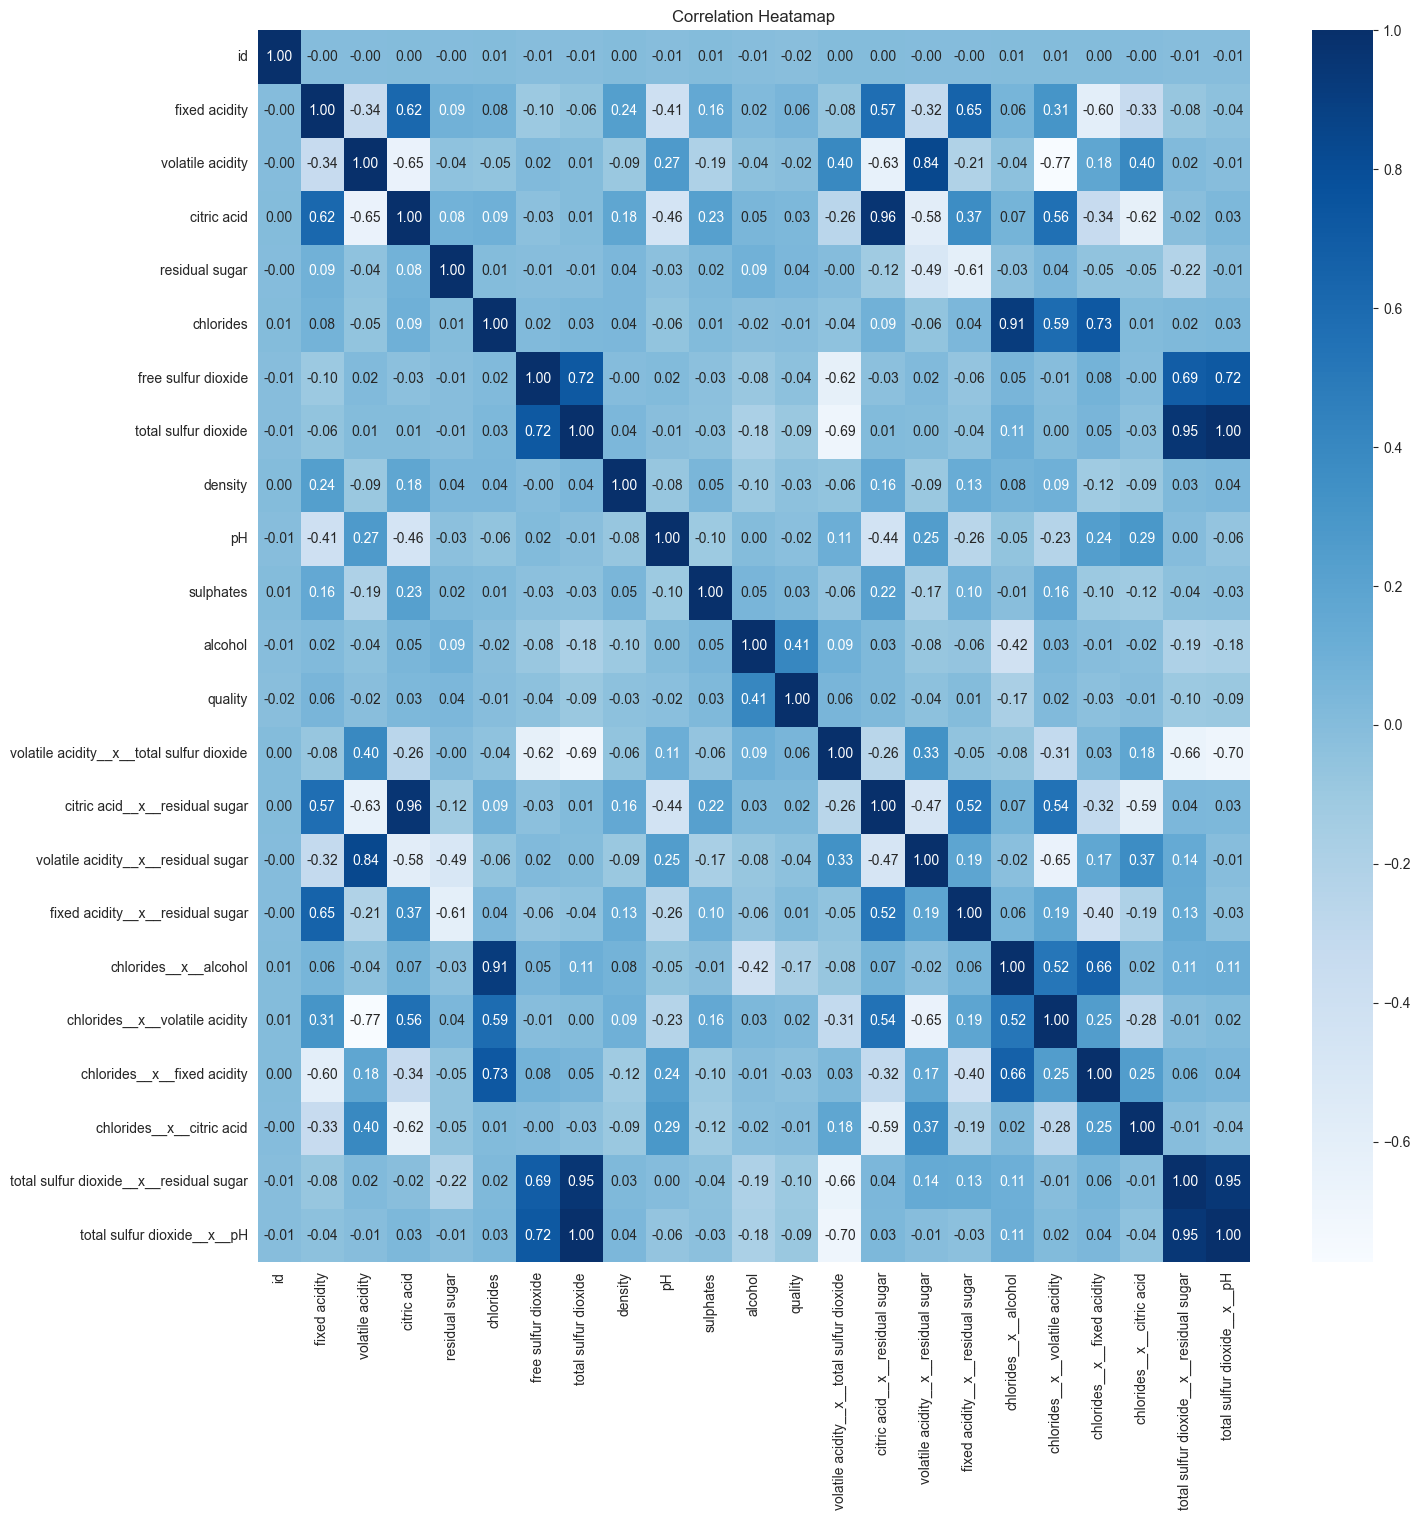

In [9]:
plt.figure(figsize=(16,16))
corr =  df.corr()
sns.heatmap(corr, cmap='Blues', annot=True, fmt=".2f")
plt.title("Correlation Heatamap")
plt.show()

In [10]:
 df.groupby(pd.qcut(df['alcohol'], 4))['quality'].mean()

/var/folders/_d/kny02jsj5wlgqc8jdj5z6f4c0000gn/T/ipykernel_11936/1024682310.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df['alcohol'], 4))['quality'].mean()


alcohol
(8.099, 9.5]    5.373022
(9.5, 9.8]      5.373617
(9.8, 10.8]     5.696897
(10.8, 15.0]    6.179432
Name: quality, dtype: float64

# Wine Notes
## Fixed acidity:
 Acids that do not evaporate easily
 - too low -> dull wine
 - too high -> sour

** Maybe a quadratic correlation to quality? **

## Volatile Acidity:
Vinegar like acid -> undesirable
Sulfur dioxides helps suppress

** Combine this field with "total sulfer dioxide" **

## Citric Acid:
Minor acid naturally present in grapes, adds brightness

** Can balance residual sugars **

## Residual Sugars:
Sugar remaining after fermentation process
- Sweet wines: high residual sugar
- Dry wines: low residual sugar

** Balance with acidity **

## Chlorides:
Salt content
- Low amounts: minerality
- High amount: harsh and metalic

** Could interact with alcohol and acidity in mouthfeel perception **

## Free Sulfur Dioxide:
antimicrobial + antioxident
- Too little -> spoils
- Too much -> chemical smell

Helps with sweeter wines

** Counterbalanced by pH levels **

## Total Sulfur Dioxide:
Free Sulfar Dioxide + Bound Sulfur Dioxides
- Acts as preservative
- Helps with sweeter wines

** Could consider interacting with residual sugars **

## Density:
Mass per volume, drivers:
- Sugars increase density
- Alcohol decreases density

## pH:
Measure of acidity strength
- Lower means stronger acidity, brighter and fresher
- Higher leads to a duller wine

Reds are best between 3.3-3.6
Whites are best between 3.0-3.3

** Effects sulfur dioxide effectiveness **

##  Sulphates:
Winemaking additives that enhance micorbials
- moderate levels associated with higher quality

** Maybe a quadratic correlation to quality? **

